In [1]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [2]:
import keras
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from sklearn import preprocessing

from cataclop.ml import preprocessing as cataclop_preprocessing

In [3]:
from cataclop.ml.pipeline import factories

dataset = factories.Dataset.factory('default', params={
    "from": "2020-01-01",
    "to": "2020-07-10"
})
dataset.load(force=False)

6822 races


In [161]:
race_features = ['prize', 'declared_player_count']
race_features += ['odds_{:d}'.format(i) for i in range(10)]


horse_features = ['age'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

for f in dataset.agg_features:
        if f.startswith('final_odds'):
            continue
        horse_features.append(f)
        horse_features.append('{}_r'.format(f))
        #horse_features.append('{}_std'.format(f))
        horse_features.append('{}_mean'.format(f))
        #for s in dataset.agg_features_funcs:
            #features.append('{}_{}'.format(f, s[0]))

horse_cat_features = ['horse_sex', 'horse_breed']
race_cat_features = ['category', 'sub_category']

race_features = sorted(list(set(race_features)))
horse_features = sorted(list(set(horse_features)))
horse_cat_features = sorted(list(set(horse_cat_features)))
race_cat_features = sorted(list(set(race_cat_features)))

features = race_features + horse_features
cat_features = race_cat_features + horse_cat_features

print(len(features), features)
print(len(cat_features), cat_features)

76 ['declared_player_count', 'odds_0', 'odds_1', 'odds_2', 'odds_3', 'odds_4', 'odds_5', 'odds_6', 'odds_7', 'odds_8', 'odds_9', 'prize', 'age', 'handicap_distance', 'handicap_distance_mean', 'handicap_distance_r', 'handicap_weight', 'handicap_weight_mean', 'handicap_weight_r', 'hist_1_days', 'hist_1_days_mean', 'hist_1_days_r', 'hist_1_pos', 'hist_1_pos_mean', 'hist_1_pos_r', 'hist_2_days', 'hist_2_days_mean', 'hist_2_days_r', 'hist_2_pos', 'hist_2_pos_mean', 'hist_2_pos_r', 'hist_3_days', 'hist_3_days_mean', 'hist_3_days_r', 'hist_3_pos', 'hist_3_pos_mean', 'hist_3_pos_r', 'hist_4_pos', 'hist_5_pos', 'hist_6_pos', 'placed_2_count', 'placed_2_count_mean', 'placed_2_count_r', 'placed_3_count', 'placed_3_count_mean', 'placed_3_count_r', 'placed_earnings', 'placed_earnings_mean', 'placed_earnings_r', 'post_position', 'post_position_mean', 'post_position_r', 'prev_year_earnings', 'prev_year_earnings_mean', 'prev_year_earnings_r', 'race_count', 'race_count_mean', 'race_count_r', 'trainer_a

In [153]:
from dill import dump, load

MODEL_PATH = '/Users/pourquoi/workspace/cataclop/cataclop-django/var/models/keras-pair-pos3/'

NAN_FLAG = 0

df = dataset.players.copy()
df = df.groupby('race_id').filter(lambda r: (r['trueskill_mu'] == 25).sum() < r['declared_player_count'].max()/2 and r['position'].min() == 1 and r['winner_dividend'].max() > 0 and r['odds_0'].min() != dataset.params['nan_flag'] and r['odds_1'].min() != dataset.params['nan_flag'] )
#df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1 and r['winner_dividend'].max() > 0 and r['odds_0'].min() != dataset.params['nan_flag'] and r['odds_1'].min() != dataset.params['nan_flag'] )
df.reset_index(inplace=True)
df.loc[:, features] = df.loc[:, features].fillna(NAN_FLAG)

df['position'] = df['position'].fillna(20)

scaler = load(open(MODEL_PATH + '/scaler.pkl', 'rb'))
scaled = scaler.transform(df.loc[:, features].values)

df['final_odds_ref_real'] = df['final_odds_ref'].copy()
df['declared_player_count_real'] = df['declared_player_count'].copy()
df['prize_real'] = df['prize'].copy()

df.loc[:, features] = scaled

In [162]:
df = df.loc[:,~df.columns.duplicated()]

horse_dummies = load(open(MODEL_PATH + '/horse_dummies.pkl', 'rb'))

df_horse_dummies = cataclop_preprocessing.get_dummy_values(df, horse_dummies)

df = pd.concat([df, df_horse_dummies], axis=1)

race_dummies = load(open(MODEL_PATH + '/race_dummies.pkl', 'rb'))

df_race_dummies = cataclop_preprocessing.get_dummy_values(df, race_dummies)

df = pd.concat([df, df_race_dummies], axis=1)


all_horse_features = sorted(list(set(horse_features + list(df_horse_dummies.columns))))

all_race_features = sorted(list(set(race_features + list(df_race_dummies.columns))))


print(len(all_horse_features), all_horse_features)
print(len(all_race_features), all_race_features)

df = df.loc[:,~df.columns.duplicated()]

74 ['age', 'handicap_distance', 'handicap_distance_mean', 'handicap_distance_r', 'handicap_weight', 'handicap_weight_mean', 'handicap_weight_r', 'hist_1_days', 'hist_1_days_mean', 'hist_1_days_r', 'hist_1_pos', 'hist_1_pos_mean', 'hist_1_pos_r', 'hist_2_days', 'hist_2_days_mean', 'hist_2_days_r', 'hist_2_pos', 'hist_2_pos_mean', 'hist_2_pos_r', 'hist_3_days', 'hist_3_days_mean', 'hist_3_days_r', 'hist_3_pos', 'hist_3_pos_mean', 'hist_3_pos_r', 'hist_4_pos', 'hist_5_pos', 'hist_6_pos', 'horse_breed_value_ANGLO ARABE', 'horse_breed_value_AQPS', 'horse_breed_value_PUR-SANG', 'horse_breed_value_TROTTEUR ETRANGER', 'horse_breed_value_TROTTEUR FRANCAIS', 'horse_sex_value_ANGLO ARABE', 'horse_sex_value_AQPS', 'horse_sex_value_PUR-SANG', 'horse_sex_value_TROTTEUR ETRANGER', 'horse_sex_value_TROTTEUR FRANCAIS', 'placed_2_count', 'placed_2_count_mean', 'placed_2_count_r', 'placed_3_count', 'placed_3_count_mean', 'placed_3_count_r', 'placed_earnings', 'placed_earnings_mean', 'placed_earnings_r', 

In [167]:
model = keras.models.load_model(MODEL_PATH + '/model.h5')
#model.load_weights('/tmp/weights.best.hdf5')

In [168]:
model.summary()

Model: "sequential_249"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_483 (Dense)            (None, 60)                5820      
_________________________________________________________________
dropout_242 (Dropout)        (None, 60)                0         
_________________________________________________________________
activation_483 (Activation)  (None, 60)                0         
_________________________________________________________________
dense_484 (Dense)            (None, 2)                 122       
_________________________________________________________________
activation_484 (Activation)  (None, 2)                 0         
Total params: 5,942
Trainable params: 5,942
Non-trainable params: 0
_________________________________________________________________


In [169]:
def make_Xy(df, train=True):
    
    X = df[sorted(all_horse_features + all_race_features)]

    y1 = np.log(1+ (df['position'] / df['declared_player_count_real']))
    y2 = np.clip((df['winner_dividend'] / 100), 0, 60) / 60
    y3 = np.clip((df['placed_dividend'] / 100), 0, 60) / 60

    y = np.transpose(np.array([y2, y3]))
                
    return (X, y)

In [ ]:
#X, y, back_idx = make_Xy(df, train=False)

In [170]:
X, y = make_Xy(df, False)

In [165]:
X.shape

(59759, 96)

In [175]:
X[0:5]

,age,category_value_ATTELE,category_value_HAIE,category_value_MONTE,category_value_PLAT,category_value_STEEPLECHASE,declared_player_count,handicap_distance,handicap_distance_mean,handicap_distance_r,...,trueskill_mu_r,trueskill_sigma,trueskill_sigma_mean,trueskill_sigma_r,victory_count,victory_count_mean,victory_count_r,victory_earnings,victory_earnings_mean,victory_earnings_r
0,0.000000,1.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,...,1.027227,0.693674,-0.179365,0.941900,-0.5,-0.879479,66621.276245,-1.261658,-1.655975,0.388523
1,0.000000,1.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,...,0.875580,0.310931,-0.179365,0.410512,-0.5,-0.879479,66621.276245,-1.175586,-1.655975,0.513892
2,0.000000,1.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,...,0.809494,-0.229100,-0.179365,-0.339249,-0.5,-0.879479,66621.276245,-1.184190,-1.655975,0.501359
3,0.000000,1.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,...,0.204032,-0.127431,-0.179365,-0.198096,-0.5,-0.879479,66621.276245,-1.160811,-1.655975,0.535413
4,0.333333,1.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,...,-1.073833,0.294240,-0.179365,0.387340,-0.5,-0.879479,66621.276245,-1.154999,-1.655975,0.543878


In [176]:
X[0:1].values

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         4.00000000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  2.30300661e-01,
         9.99997849e-01, -1.42857143e-01,  4.26893939e-01,
        -3.68524883e-01,  0.00000000e+00,  3.29754652e-01,
         9.99991455e-01,  5.71428571e-01,  9.85183547e-01,
         4.41144519e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -2.85714286e-01,  3.34923664e-01,
        -5.42161661e-01,  5.71428571e-01,  6.25000000e-01,
        -6.25000000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -8.33333333e-01,
        -7.00000000e-01,  1.84000000e+00,  5.41935484e+00,
         4.05128205e+00,  2.46296296e+00,  3.48684211e+0

In [171]:
for i in range(y.shape[1]):
    df['pred_y{}'.format(i+1)] = 0
    df['pred_n{}'.format(i+1)] = 0
    df['pred_std{}'.format(i+1)] = 0
    df['pred_mean{}'.format(i+1)] = 0

df['pred_total'] = 0
df['odds_n'] = 0
df['stash'] = 0

predictions = model.predict(X)
    
p = np.transpose(predictions)

for i in range(y.shape[1]):
    df['pred_y{}'.format(i+1)] = p[i]


def fast_bet(r):

    for i in range(y.shape[1]):
        p = 'pred_y{}'.format(i+1)
        asc = False#True if i == 0 else False
        s = r.sort_values(by=p, ascending=asc)
        o = s.index.sort_values(ascending=True, return_indexer=True)

        r['pred_n{}'.format(i+1)] = o[1]
        r['pred_std{}'.format(i+1)] = r[p].std()
        r['pred_mean{}'.format(i+1)] = r[p].mean()

    s = r.sort_values(by='final_odds')
    o = s.index.sort_values(ascending=True, return_indexer=True)

    r['odds_n'] = o[1]

    return r

df = df.groupby('race_id').apply(fast_bet)


In [204]:
from skopt.space.space import Space
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical

categories = list(df['sub_category'].value_counts().index[0:10])

space = [Real(0, df_test['pred_std2'].max(), name='std_min'),
         Real(0, 1, name='win_or_placed'),
         Integer(0, 1, name='bet_mul1'),
         Integer(0, 1, name='bet_mul2'),
         #, 'INCONNU', 'AUTOSTART', 'COURSE_A_CONDITIONS'
          Categorical(['HANDICAP', 'HANDICAP_DIVISE', 'INCONNU', 'AUTOSTART', 'COURSE_A_CONDITIONS'], name='sub_categories'),
          Integer(0, 10, name='n1'),
          Integer(0, 20, name='n2'),
         Integer(0, 30, name='odds_min'),
         Integer(0, 60, name='odds_max')
        ]

g = None
df_test = df

def shape_quality(shape):
    n_max = 0;
    n_min = 0;
    c_min = None;
    c_max = None;
    
    if len(shape) == 0:
        return 0
    
    for x in np.nditer(shape):
        if c_max is None or x > c_max:
            c_max = x
            n_max = n_max + 1 + ( np.sqrt((x - c_max) * (x - c_max)) )
            
        
        if c_min is None or x < c_min:
            c_min = x
            n_min = n_min + 1 + ( np.sqrt((c_min - x) * (c_min - x)) )
            
    if n_min == 0:
        return 0
    
    #if n_max > n_min:
    return len(shape) * n_max / n_min
    #else:
    #    return -len(shape) * n_max / n_min

@use_named_args(space)
def ff(**params):
    global df_test
    global categories
    global g
    
    print(params)
    
    n1 = params['n1']
    n2 = params['n2']
    
    if n2 < n1:
        tmp = n1
        n1 = n2
        n2 = tmp

    odds_min = params['odds_min']
    odds_max = params['odds_max']

    if odds_max < odds_min:
        tmp = odds_min
        odds_min = odds_max
        odds_max = tmp

    df_test['bet'] = 1 + np.clip(df_test['odds_n'], 0, 5) * params['bet_mul1'] + np.floor(params['bet_mul2'] / (df_test['odds_n']+1))
    df_test['profit'] = np.ceil(df_test['bet'] * params['win_or_placed']) * (df_test['winner_dividend'].fillna(0.)/100.-1.0) + np.ceil(df_test['bet'] * (1. - params['win_or_placed'])) * (df_test['placed_dividend'].fillna(0.)/100.-1.0)

    #(df_test['sub_category'] == params['sub_categories'])
    g = df_test[ (df_test['sub_category'] == params['sub_categories']) & (df_test['pred_std1'] > params['std_min']) & (df_test['pred_n1'] >= n1) & (df_test['pred_n1'] <= n2) & (df_test['final_odds_ref_real'] < odds_max) & (df_test['final_odds_ref_real'] > odds_min) ].copy()
    
    g['stash'] = g['profit'].cumsum()

    p = g['profit'].mean()
    winc = (g['position'] == 1).sum()
    losec = (g['position'] != 1).sum()
    c = len(g)
    
    quality = shape_quality(g['stash'].values)

    r = winc / losec if losec else 0

    print('$$ ', p)
    print('p/b', g['profit'].sum() / g['bet'].sum())
    print('%', r)
    print('c', c)
    
    print(quality)

    return 0 if np.isnan(p) or np.isnan(r) else -quality#-p * c * c * (1+r)# * c * np.log(c) * r * np.log(1+r)

In [205]:
from skopt import gp_minimize, forest_minimize, dummy_minimize

res_gp = gp_minimize(ff, space, n_calls=500, random_state=0)

print("Best score={}".format(res_gp.fun))

{'std_min': 0.003992361979321109, 'win_or_placed': 0.8442657485810175, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'AUTOSTART', 'n1': 4, 'n2': 6, 'odds_min': 1.7013893195232959, 'odds_max': 16.359377674806794}
$$  -3.4799999999999995
p/b -0.9157894736842105
% 0.0
c 5
1.25
{'std_min': 0.003216714792741687, 'win_or_placed': 0.8121687287754934, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 3, 'n2': 13, 'odds_min': 11.047246195216442, 'odds_max': 57.429309537182796}
$$  -0.19913294797687867
p/b -0.19913294797687867
% 0.03592814371257485
c 346
47.18181818181818
{'std_min': 0.0009451567953254369, 'win_or_placed': 0.8700872583584366, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'INCONNU', 'n1': 7, 'n2': 14, 'odds_min': 17.460593762253218, 'odds_max': 32.242393766940644}
$$  -0.6306896551724138
p/b -0.6306896551724138
% 0.02292768959435626
c 580
14.948453608247423
{'std_min': 0.005108704848382334, 'win_or_placed': 0.10590760718779216, 'bet_mul1': 0, 'bet_m

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


$$  -0.5825701624815361
p/b -0.5825701624815361
% 0.027314112291350532
c 677
5.8111587982832615
{'std_min': 0.0061836242605089915, 'win_or_placed': 0.21682213762754293, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'INCONNU', 'n1': 9, 'n2': 18, 'odds_min': 2.493374778918072, 'odds_max': 16.66311367686195}
$$  nan
p/b nan
% 0
c 0
0
{'std_min': 0.0012081324013431722, 'win_or_placed': 0.5888377728660474, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 11, 'odds_min': 13.309654087060336, 'odds_max': 58.3933398487628}
$$  -0.47396335583413696
p/b -0.47396335583413696
% 0.028769841269841268
c 1037
19.44375
{'std_min': 0.004919124870908801, 'win_or_placed': 0.2268147391105705, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 15, 'odds_min': 10.78835697645522, 'odds_max': 57.47352021317632}
$$  0.10625000000000012
p/b 0.10625000000000012
% 0.06666666666666667
c 32
64.0
{'std_min': 0.004952367919433836, 'win_or_placed'

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


{'std_min': 0.004940728296820092, 'win_or_placed': 0.2288055145610992, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 0, 'n2': 18, 'odds_min': 14.925499804481085, 'odds_max': 16.24892899418241}
$$  -1.0166666666666666
p/b -1.0166666666666666
% 0.0
c 6
1.5
{'std_min': 0.0049391007551521935, 'win_or_placed': 0.6569740608390263, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 0, 'n2': 18, 'odds_min': 15.60155333286709, 'odds_max': 60.0}
$$  -4.554545454545455
p/b -0.7648854961832061
% 0.0
c 22
1.1
{'std_min': 0.004937511060290282, 'win_or_placed': 0.6635436061947232, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 0, 'n2': 8, 'odds_min': 15.608056057562791, 'odds_max': 59.99069785944719}
$$  -1.238888888888889
p/b -1.238888888888889
% 0.0
c 18
1.0588235294117647
{'std_min': 0.004937925346139885, 'win_or_placed': 0.9372491177118414, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


{'std_min': 0.006413221386022698, 'win_or_placed': 0.18737863437145622, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 10.232686894094956, 'odds_max': 24.873743816861847}
$$  1.5833333333333333
p/b 0.3064516129032258
% 0.2
c 6
6.0
{'std_min': 0.003660574076778278, 'win_or_placed': 0.0, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 17, 'odds_min': 0.039046684394135424, 'odds_max': 59.9981227648569}
$$  nan
p/b nan
% 0
c 0
0


/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


{'std_min': 0.003177800112966453, 'win_or_placed': 0.18083648067987063, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 8, 'odds_min': 8.558556516424488, 'odds_max': 36.72735875432198}
$$  -0.06056338028169022
p/b -0.01115145228215769
% 0.06927710843373494
c 355
229.7058823529412
{'std_min': 0.003172290455669602, 'win_or_placed': 0.18273268558195332, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.509564830714812, 'odds_max': 36.08436587205402}
$$  0.3179389312977099
p/b 0.3179389312977099
% 0.07818930041152264
c 262
205.85714285714286
{'std_min': 0.0031943582745614075, 'win_or_placed': 0.18573264663579894, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 11, 'odds_min': 6.858834309793247, 'odds_max': 37.19815965649392}
$$  -0.6070726915520629
p/b -0.1156437125748503
% 0.06041666666666667
c 509
43.628571428571426
{'std_min': 0.002233985484115044, 'win_or_pla

{'std_min': 0.0031838560432524868, 'win_or_placed': 0.1824591103473429, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.638577940163302, 'odds_max': 36.96803677595353}
$$  0.3972972972972974
p/b 0.07329059829059832
% 0.07468879668049792
c 259
237.41666666666666
{'std_min': 0.003179741266302988, 'win_or_placed': 0.6128441619777142, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 7, 'n2': 5, 'odds_min': 8.696814401637532, 'odds_max': 36.73687593952447}
$$  1.2697674418604652
p/b 0.23102961918194642
% 0.075
c 129
34.4
{'std_min': 0.0031887585812043176, 'win_or_placed': 0.14611267234807976, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.538995152927548, 'odds_max': 36.66936478463151}
$$  0.2923664122137403
p/b 0.05401974612129758
% 0.07818930041152264
c 262
288.2
{'std_min': 0.0031894771032422373, 'win_or_placed': 0.6623520610770055, 'bet_mul1': 1, 'be

{'std_min': 0.003172902341893495, 'win_or_placed': 0.1311330536678869, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.523596077026145, 'odds_max': 35.79159057337701}
$$  0.32030651340996147
p/b 0.05920679886685548
% 0.07851239669421488
c 261
319.0
{'std_min': 0.003170397216142446, 'win_or_placed': 0.144375282993488, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.492573309778265, 'odds_max': 35.90598614631929}
$$  0.2984848484848483
p/b 0.05549295774647884
% 0.07755102040816327
c 264
290.4
{'std_min': 0.0031743465439045193, 'win_or_placed': 0.17521141875321342, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.49073371684224, 'odds_max': 35.68276860764348}
$$  0.48181818181818187
p/b 0.08957746478873241
% 0.07755102040816327
c 264
264.0
{'std_min': 0.0032063038162179233, 'win_or_placed': 0.8303723388175756, 'bet_mul1': 1, 'b

{'std_min': 0.003160763103509803, 'win_or_placed': 0.13217623901882322, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.52311546342417, 'odds_max': 35.25278083918676}
$$  0.38484848484848483
p/b 0.07104895104895105
% 0.07755102040816327
c 264
352.0
{'std_min': 0.0031548327145258033, 'win_or_placed': 0.1179560792017031, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.536812224514158, 'odds_max': 35.120849190348565}
$$  0.31343283582089554
p/b 0.05785123966942149
% 0.07630522088353414
c 268
327.55555555555554
{'std_min': 0.003687315441378543, 'win_or_placed': 0.3068536392480006, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 3, 'n2': 9, 'odds_min': 12.580680108418017, 'odds_max': 53.636648069280284}
$$  -2.514141414141414
p/b -0.4389770723104056
% 0.03125
c 99
7.2439024390243905
{'std_min': 0.00316283929157636, 'win_or_placed': 0.1010310434502352, 'b

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


{'std_min': 0.003185803100118439, 'win_or_placed': 0.29675427578550573, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 8, 'odds_min': 8.550581779223133, 'odds_max': 36.94952848902203}
$$  0.0687323943661972
p/b 0.0687323943661972
% 0.06927710843373494
c 355
177.5
{'std_min': 0.0031576675847187164, 'win_or_placed': 0.11392780056246468, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.512815606941883, 'odds_max': 35.20804708325169}
$$  0.32499999999999996
p/b 0.32499999999999996
% 0.07755102040816327
c 264
226.28571428571428
{'std_min': 0.0027086803844557864, 'win_or_placed': 0.9462331880427096, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 0, 'n2': 6, 'odds_min': 6.047445593191315, 'odds_max': 33.43680946478808}
$$  -0.21518218623481783
p/b -0.21518218623481783
% 0.08333333333333333
c 494
23.80722891566265
{'std_min': 0.0031589499622484136, 'win_or_placed': 0.03240

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


{'std_min': 0.003149761215945547, 'win_or_placed': 0.4582524637762886, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.555080165631406, 'odds_max': 35.92952679505905}
$$  0.29813432835820897
p/b 0.29813432835820897
% 0.07630522088353414
c 268
229.71428571428572
{'std_min': 0.0031579213802112233, 'win_or_placed': 0.10976253843094769, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.542860703428659, 'odds_max': 35.11863057307998}
$$  0.32499999999999996
p/b 0.32499999999999996
% 0.07755102040816327
c 264
226.28571428571428
{'std_min': 0.0033166655009894655, 'win_or_placed': 0.003402565793148101, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 2, 'n2': 9, 'odds_min': 10.168209415341774, 'odds_max': 33.13654497778079}
$$  -0.17124463519313313
p/b -0.17124463519313313
% 0.05429864253393665
c 233
63.54545454545455
{'std_min': 0.0035146502403900284, 'win_or

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


{'std_min': 0.003010116213697425, 'win_or_placed': 0.736871941303717, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 7.978528575034442, 'odds_max': 35.626015511593195}
$$  0.8668918918918922
p/b 0.16230234029095514
% 0.06859205776173286
c 296
124.63157894736842
{'std_min': 0.003165492964428471, 'win_or_placed': 0.22071072677905812, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 8, 'odds_min': 8.582007997302593, 'odds_max': 36.354556419402115}
$$  0.0687323943661972
p/b 0.0687323943661972
% 0.06927710843373494
c 355
177.5
{'std_min': 0.0024786591563330123, 'win_or_placed': 0.6948202456445184, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 3, 'n2': 12, 'odds_min': 24.022313549651905, 'odds_max': 13.121530650269003}
$$  -0.9734693877551021
p/b -0.9734693877551021
% 0.035211267605633804
c 147
1.860759493670886
{'std_min': 0.0031958041970033186, 'win_or_placed': 0.3462146020172366

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


{'std_min': 0.005666552068530341, 'win_or_placed': 0.5122710922740582, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 18, 'odds_min': 25.573897904396077, 'odds_max': 23.708684016082962}
$$  -2.0
p/b -2.0
% 0.0
c 1
1.0
{'std_min': 0.0031918180623335475, 'win_or_placed': 0.1138241507739867, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.544374867242803, 'odds_max': 35.044578798329376}
$$  0.32030651340996147
p/b 0.05920679886685548
% 0.07851239669421488
c 261
319.0
{'std_min': 0.0032187126721267656, 'win_or_placed': 0.3557899658717725, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 8, 'odds_min': 8.644355074059066, 'odds_max': 35.23641170330003}
$$  0.26253687315634217
p/b 0.04829083016820401
% 0.0694006309148265
c 339
214.10526315789474
{'std_min': 0.0031571232470662064, 'win_or_placed': 0.01170729006254368, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories':

{'std_min': 0.0029913699648823726, 'win_or_placed': 0.11217942521509064, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 1, 'n2': 6, 'odds_min': 8.643211565046533, 'odds_max': 35.592757507212106}
$$  0.16113074204946984
p/b 0.16113074204946984
% 0.06792452830188679
c 283
141.5
{'std_min': 0.0007180269182813595, 'win_or_placed': 0.36664324137432264, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'AUTOSTART', 'n1': 0, 'n2': 1, 'odds_min': 27.354939500815536, 'odds_max': 22.32113465316933}
$$  0.06976744186046495
p/b 0.06976744186046495
% 0.023809523809523808
c 43
2.8666666666666667
{'std_min': 0.0011216948795565473, 'win_or_placed': 0.29760136172534774, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 6, 'n2': 2, 'odds_min': 22.885714863148458, 'odds_max': 30.062229623708713}
$$  3.0253968253968258
p/b 0.5165311653116532
% 0.05
c 126
420.0
{'std_min': 0.001115409671983449, 'win_or_placed': 0.3050956632763566, 'bet_mul1': 0, 'bet_m

{'std_min': 0.0011174009981857276, 'win_or_placed': 0.25430959806165865, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 6, 'n2': 2, 'odds_min': 22.88831118758619, 'odds_max': 30.17455313233798}
$$  3.0253968253968258
p/b 0.5165311653116532
% 0.05
c 126
420.0
{'std_min': 0.0012049450860774347, 'win_or_placed': 0.7644353153307318, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.655723299872363, 'odds_max': 49.88086359834653}
$$  2.31375
p/b 0.3943892045454546
% 0.034482758620689655
c 240
800.0
{'std_min': 0.0010975053043795018, 'win_or_placed': 0.5829321122090017, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 6, 'n2': 2, 'odds_min': 22.85287155442831, 'odds_max': 31.39835851664036}
$$  3.085314685314686
p/b 0.526491646778043
% 0.043795620437956206
c 143
166.83333333333334
{'std_min': 0.0011479914902469011, 'win_or_placed': 0.5345597343893549, 'bet_mul1': 0, 'bet_mul2': 0, 

{'std_min': 0.0011962390790233046, 'win_or_placed': 0.5159646306499884, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.663003586179162, 'odds_max': 49.65575919799396}
$$  0.48806584362139915
p/b 0.48806584362139915
% 0.03404255319148936
c 243
1134.0
{'std_min': 0.0011962161332509187, 'win_or_placed': 0.3513514132758711, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.66301856731652, 'odds_max': 49.655832234238545}
$$  1.6691358024691356
p/b 0.2846315789473684
% 0.03404255319148936
c 243
1215.0
{'std_min': 0.0011930527925847303, 'win_or_placed': 0.5732360621662281, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.58489730562312, 'odds_max': 49.68075340914427}
$$  0.48806584362139915
p/b 0.48806584362139915
% 0.03404255319148936
c 243
1134.0
{'std_min': 0.0011685097173304193, 'win_or_placed': 0.5614073637202938, 'bet_mul1'

{'std_min': 0.0011774419386222966, 'win_or_placed': 0.60775384985154, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.648993858127817, 'odds_max': 57.45792710280293}
$$  0.3237735849056603
p/b 0.3237735849056603
% 0.0311284046692607
c 265
795.0
{'std_min': 0.0011850431261530658, 'win_or_placed': 0.059449863771375414, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.619712159717412, 'odds_max': 50.088524650078924}
$$  0.4778688524590164
p/b 0.4778688524590164
% 0.03389830508474576
c 244
1138.6666666666667
{'std_min': 0.0011761466425104262, 'win_or_placed': 0.5201037387984409, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.650262770905453, 'odds_max': 12.64147744219116}
$$  -2.574493927125506
p/b -0.4561692969870875
% 0.037815126050420166
c 247
6.798165137614679
{'std_min': 0.0011879174111792355, 'win_or_placed': 0.5482651

{'std_min': 0.0011766253055526578, 'win_or_placed': 0.2623813158560946, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.63024515691863, 'odds_max': 50.17964723838657}
$$  0.46775510204081633
p/b 0.46775510204081633
% 0.03375527426160337
c 245
1143.3333333333333
{'std_min': 0.001174239375443608, 'win_or_placed': 0.7305303266982988, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.64058670671872, 'odds_max': 50.17030991394663}
$$  0.5145748987854251
p/b 0.5145748987854251
% 0.03347280334728033
c 247
1070.3333333333333
{'std_min': 0.0011737737953586987, 'win_or_placed': 0.8926974956166793, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.641001004471285, 'odds_max': 50.17723057941217}
$$  0.5145748987854251
p/b 0.5145748987854251
% 0.03347280334728033
c 247
1070.3333333333333
{'std_min': 0.0011732099586497222, 'win_or_placed'

{'std_min': 0.0011619218810042585, 'win_or_placed': 0.25598663783290665, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.640379853110797, 'odds_max': 50.324072745008465}
$$  0.5145748987854251
p/b 0.5145748987854251
% 0.03347280334728033
c 247
1070.3333333333333
{'std_min': 0.001161370000973121, 'win_or_placed': 0.3143100505334029, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.641212192552537, 'odds_max': 50.33257308625493}
$$  0.5145748987854251
p/b 0.5145748987854251
% 0.03347280334728033
c 247
1070.3333333333333
{'std_min': 0.001160748318346764, 'win_or_placed': 0.3285811265738075, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.64158259589287, 'odds_max': 50.34230166420666}
$$  0.5145748987854251
p/b 0.5145748987854251
% 0.03347280334728033
c 247
1070.3333333333333
{'std_min': 0.001159253062656781, 'win_or_placed':

{'std_min': 0.0011460189812486548, 'win_or_placed': 0.7348923007415537, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.650775030498792, 'odds_max': 50.57178038390445}
$$  0.5145748987854251
p/b 0.5145748987854251
% 0.03347280334728033
c 247
1070.3333333333333
{'std_min': 0.0011452387029625458, 'win_or_placed': 0.050304071198170285, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.651124422105244, 'odds_max': 50.58287768269152}
$$  0.5145748987854251
p/b 0.5145748987854251
% 0.03347280334728033
c 247
1070.3333333333333
{'std_min': 0.003530957767713291, 'win_or_placed': 0.023332718185151185, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.651563770849915, 'odds_max': 50.68796447461066}
$$  0.8282608695652173
p/b 0.8282608695652173
% 0.045454545454545456
c 46
12.545454545454545
{'std_min': 0.0011525773433607818, 'win_or_pla

{'std_min': 0.001136639492543267, 'win_or_placed': 0.7657600152820355, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.658916284618545, 'odds_max': 50.77428630416173}
$$  2.9608000000000003
p/b 0.5045671438309476
% 0.03734439834024896
c 250
916.6666666666666
{'std_min': 0.0011360789544105738, 'win_or_placed': 0.7588545879541848, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.65926103743751, 'odds_max': 50.78363085355344}
$$  0.6732
p/b 0.6732
% 0.03734439834024896
c 250
1166.6666666666667
{'std_min': 0.001135262831783345, 'win_or_placed': 0.30016969047500974, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.659759516488716, 'odds_max': 50.797491431546284}
$$  0.6732
p/b 0.6732
% 0.03734439834024896
c 250
1166.6666666666667
{'std_min': 0.0011344483024634908, 'win_or_placed': 0.07181742048382808, 'bet_mul1': 0, 'bet_mul2':

{'std_min': 0.00046533521175744073, 'win_or_placed': 0.782485432655757, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.647943321888107, 'odds_max': 51.39578561782152}
$$  1.7405579399141624
p/b 0.29526756461594456
% 0.04017857142857143
c 466
6524.0
{'std_min': 0.000737007793907549, 'win_or_placed': 0.7411680864413837, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 20.54091256397956, 'odds_max': 52.68738494385441}
$$  0.09638009049773748
p/b 0.09638009049773748
% 0.030303030303030304
c 442
5304.0
{'std_min': 0.0007228184803292145, 'win_or_placed': 0.5039784423648125, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 23.508287063994683, 'odds_max': 53.94064085601972}
$$  0.17451523545706368
p/b 0.17451523545706368
% 0.03142857142857143
c 361
220.61111111111111
{'std_min': 0.0008701389035342858, 'win_or_placed': 0.312526919046231

{'std_min': 0.0009095514736747855, 'win_or_placed': 0.23217202169320905, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.275574419787553, 'odds_max': 51.47425528012162}
$$  0.3660377358490567
p/b 0.3660377358490567
% 0.035830618892508145
c 318
1484.0
{'std_min': 0.0009054436687444827, 'win_or_placed': 0.714391400663695, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.269485960152277, 'odds_max': 51.49692300400782}
$$  1.700625
p/b 0.2890069038767924
% 0.03559870550161812
c 320
1066.6666666666667
{'std_min': 0.0009038136321644677, 'win_or_placed': 0.18725964692208175, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.26771863665214, 'odds_max': 51.507021781654295}
$$  0.3593750000000001
p/b 0.3593750000000001
% 0.03559870550161812
c 320
1493.3333333333333
{'std_min': 0.0008953143064325363, 'win_or_placed': 0.815309337099779

{'std_min': 0.0008166624301928618, 'win_or_placed': 0.6132213207809002, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.066960239899416, 'odds_max': 51.993989837531764}
$$  0.2672672672672673
p/b 0.2672672672672673
% 0.034161490683229816
c 333
1443.0
{'std_min': 0.0008128519578733332, 'win_or_placed': 0.515802122388678, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.061372909943653, 'odds_max': 52.02171518627375}
$$  0.25352941176470595
p/b 0.25352941176470595
% 0.03343465045592705
c 340
1360.0
{'std_min': 0.0008091191273904649, 'win_or_placed': 0.5241938100565681, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.0554681086804, 'odds_max': 52.06699436315956}
$$  0.26871345029239774
p/b 0.26871345029239774
% 0.03323262839879154
c 342
1368.0
{'std_min': 0.0007176705054174048, 'win_or_placed': 0.8488024162864648, 'bet_mul1'

{'std_min': 0.0007258289372629835, 'win_or_placed': 0.5647365825737716, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.944907688504063, 'odds_max': 53.01966319221014}
$$  0.5769230769230769
p/b 0.09795918367346938
% 0.03225806451612903
c 416
653.7142857142857
{'std_min': 0.0007261203221646703, 'win_or_placed': 0.49402884510803635, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.94936353022517, 'odds_max': 52.96631634973543}
$$  0.15206812652068116
p/b 0.15206812652068116
% 0.032663316582914576
c 411
2260.5
{'std_min': 0.0007191112941887075, 'win_or_placed': 0.7412546135303346, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.934314970697095, 'odds_max': 53.068918202848096}
$$  0.12110311750599519
p/b 0.12110311750599519
% 0.03217821782178218
c 417
1146.75
{'std_min': 0.0007177572549780846, 'win_or_placed': 0.633302875451

405
{'std_min': 0.00046533521175744073, 'win_or_placed': 0.782485432655757, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.647943321888107, 'odds_max': 51.39578561782152}
$$  1.7405579399141624
p/b 0.29526756461594456
% 0.04017857142857143
c 466
6524.0
-6524.0
466
2020-01-01 13:18:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
71   2020-01-01 13:18:00        CROSS WAY    79932  0.624147  6.0       5   
72   2020-01-01 13:18:00         RARE BOY    79932  0.624147  5.0       4   
74   2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  6.0       6   
723  2020-01-03 12:55:00            FURAX    79991  0.419365  5.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  6.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  6.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  6.0       7   
841  2020-01-03 15:52:

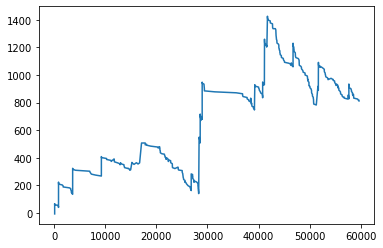

406
{'std_min': 0.000737007793907549, 'win_or_placed': 0.7411680864413837, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 20.54091256397956, 'odds_max': 52.68738494385441}
$$  0.09638009049773748
p/b 0.09638009049773748
% 0.030303030303030304
c 442
5304.0
-5304.0
442
2020-01-01 13:18:00 2020-06-30 20:15:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
71  2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72  2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74  2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723 2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815 2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824 2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
826 2020-01-03 15:35:00           SALINA    79986 -0.063929  1.0       5   
828 2020-01-03 15:35:00      N

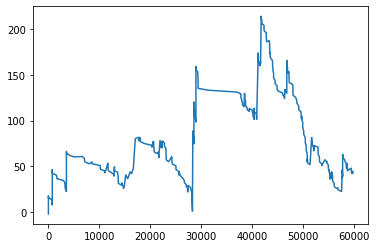

466
{'std_min': 0.0007340537940484742, 'win_or_placed': 0.7690576413907395, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.965199380773196, 'odds_max': 52.857861939689215}
$$  0.17321867321867315
p/b 0.17321867321867315
% 0.03299492385786802
c 407
4477.0
-4477.0
407
2020-01-01 13:18:00 2020-06-30 20:15:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
71  2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72  2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74  2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723 2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815 2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824 2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
826 2020-01-03 15:35:00           SALINA    79986 -0.063929  1.0       5   
828 2020-01-03 15:35:00     

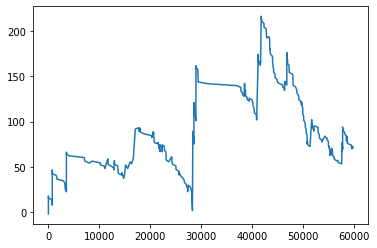

475
{'std_min': 0.0007360094368896756, 'win_or_placed': 0.01893638484049215, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.96054130504666, 'odds_max': 52.9270193602311}
$$  0.17321867321867315
p/b 0.17321867321867315
% 0.03299492385786802
c 407
4477.0
-4477.0
407
2020-01-01 13:18:00 2020-06-30 20:15:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
71  2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72  2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74  2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723 2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815 2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824 2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
826 2020-01-03 15:35:00           SALINA    79986 -0.063929  1.0       5   
828 2020-01-03 15:35:00      N

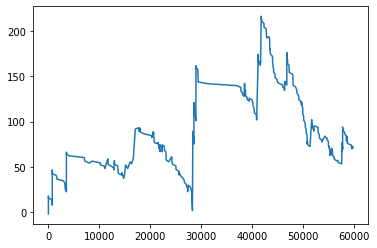

463
{'std_min': 0.0007713113998053161, 'win_or_placed': 0.9390014961012579, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.027637332260202, 'odds_max': 52.61182005156313}
$$  0.19783197831978316
p/b 0.19783197831978316
% 0.03361344537815126
c 369
4428.0
-4428.0
369
2020-01-01 13:18:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
71   2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72   2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74   2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52

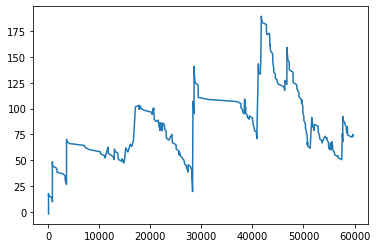

462
{'std_min': 0.0007176705054174048, 'win_or_placed': 0.8488024162864648, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.232066467749117, 'odds_max': 55.36607871292542}
$$  0.18997493734335827
p/b 0.18997493734335827
% 0.03367875647668394
c 399
4389.0
-4389.0
399
2020-01-01 13:18:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
71   2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72   2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74   2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52

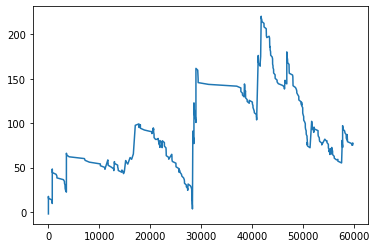

487
{'std_min': 0.0007261203221646703, 'win_or_placed': 0.49402884510803635, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.94936353022517, 'odds_max': 52.96631634973543}
$$  0.15206812652068116
p/b 0.15206812652068116
% 0.032663316582914576
c 411
2260.5
-2260.5
411
2020-01-01 13:18:00 2020-06-30 20:15:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
71  2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72  2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74  2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723 2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815 2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824 2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
826 2020-01-03 15:35:00           SALINA    79986 -0.063929  1.0       5   
828 2020-01-03 15:35:00     

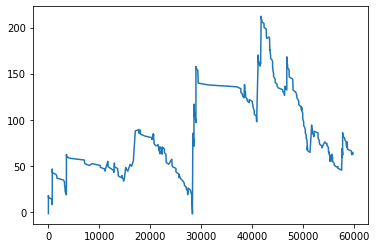

494
{'std_min': 0.0007278649887967681, 'win_or_placed': 0.403975037302343, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.94557047168455, 'odds_max': 52.9901352850175}
$$  0.15206812652068116
p/b 0.15206812652068116
% 0.032663316582914576
c 411
2260.5
-2260.5
411
2020-01-01 13:18:00 2020-06-30 20:15:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
71  2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72  2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74  2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723 2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815 2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824 2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
826 2020-01-03 15:35:00           SALINA    79986 -0.063929  1.0       5   
828 2020-01-03 15:35:00      NE

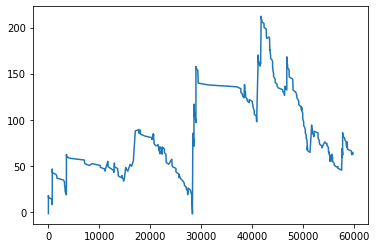

464
{'std_min': 0.0007470705477044919, 'win_or_placed': 0.16945041828688287, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.98648425384475, 'odds_max': 52.769447791356114}
$$  0.03391089108910885
p/b 0.03391089108910885
% 0.030612244897959183
c 404
1818.0
-1818.0
404
2020-01-01 13:18:00 2020-06-30 20:15:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
71  2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72  2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74  2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723 2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815 2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824 2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
826 2020-01-03 15:35:00           SALINA    79986 -0.063929  1.0       5   
828 2020-01-03 15:35:00    

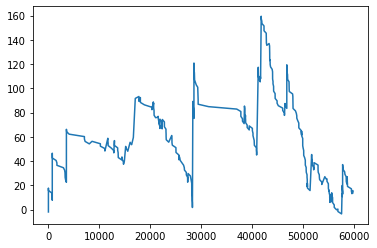

465
{'std_min': 0.000740560712700753, 'win_or_placed': 0.6600737331674928, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.97582947662351, 'odds_max': 52.813931344857224}
$$  0.03391089108910885
p/b 0.03391089108910885
% 0.030612244897959183
c 404
1818.0
-1818.0
404
2020-01-01 13:18:00 2020-06-30 20:15:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
71  2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72  2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74  2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723 2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815 2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824 2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
826 2020-01-03 15:35:00           SALINA    79986 -0.063929  1.0       5   
828 2020-01-03 15:35:00      

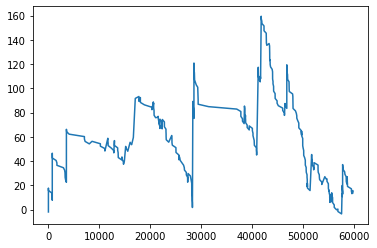

473
{'std_min': 0.0007413674666701242, 'win_or_placed': 0.7514268227984658, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.95691574033596, 'odds_max': 52.89980013868863}
$$  0.03391089108910885
p/b 0.03391089108910885
% 0.030612244897959183
c 404
1818.0
-1818.0
404
2020-01-01 13:18:00 2020-06-30 20:15:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
71  2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72  2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74  2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723 2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815 2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824 2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
826 2020-01-03 15:35:00           SALINA    79986 -0.063929  1.0       5   
828 2020-01-03 15:35:00      

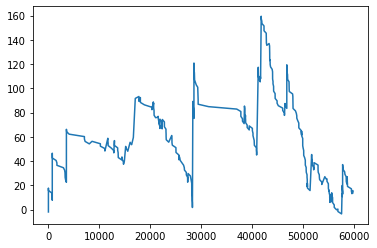

438
{'std_min': 0.0009021767957956815, 'win_or_placed': 0.4405312318624974, 'bet_mul1': 1, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.210793996293972, 'odds_max': 51.510955708132244}
$$  1.20125
p/b 0.20414232607541158
% 0.03559870550161812
c 320
1600.0
-1600.0
320
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  5.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  6.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  6.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  6.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  6.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  6.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  6.0      10   
1732 2020-01-05 15:37:00        

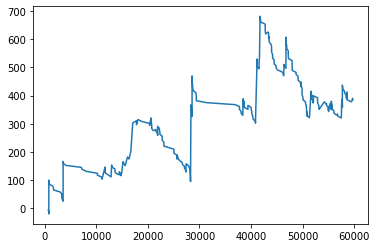

496
{'std_min': 0.0007143137442401838, 'win_or_placed': 0.10387776488550927, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 21.938247352264604, 'odds_max': 52.93554878014231}
$$  0.12052505966587117
p/b 0.12052505966587117
% 0.03201970443349754
c 419
1536.3333333333333
-1536.3333333333333
419
2020-01-01 13:18:00 2020-06-30 20:15:00
               start_at       horse_name  race_id     prize  bet  odds_n  \
71  2020-01-01 13:18:00        CROSS WAY    79932  0.624147  1.0       5   
72  2020-01-01 13:18:00         RARE BOY    79932  0.624147  1.0       4   
74  2020-01-01 13:18:00     L'ASSAUT SIX    79932  0.624147  1.0       6   
723 2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815 2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824 2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
826 2020-01-03 15:35:00           SALINA    79986 -0.063929  1.0       5   
828 

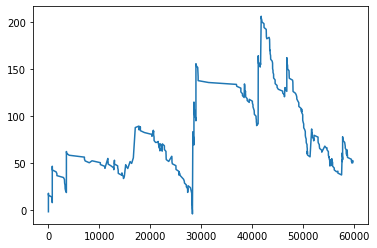

444
{'std_min': 0.0008763996819991431, 'win_or_placed': 0.461012478129892, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.167290667487972, 'odds_max': 51.654220269069796}
$$  0.3230769230769231
p/b 0.3230769230769231
% 0.03503184713375796
c 325
1516.6666666666667
-1516.6666666666667
325
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   

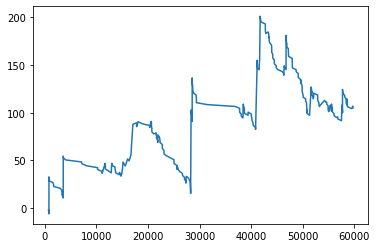

445
{'std_min': 0.0008720104911823074, 'win_or_placed': 0.8538001436887568, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.160031176470426, 'odds_max': 51.678784375181515}
$$  0.3230769230769231
p/b 0.3230769230769231
% 0.03503184713375796
c 325
1516.6666666666667
-1516.6666666666667
325
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10  

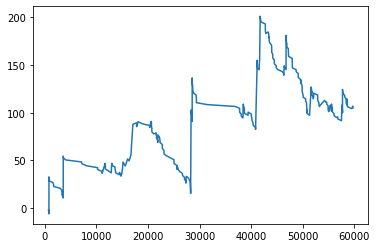

446
{'std_min': 0.0008676126266330113, 'win_or_placed': 0.5594977048933643, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.152617896578796, 'odds_max': 51.703282641342156}
$$  0.3230769230769231
p/b 0.3230769230769231
% 0.03503184713375796
c 325
1516.6666666666667
-1516.6666666666667
325
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10  

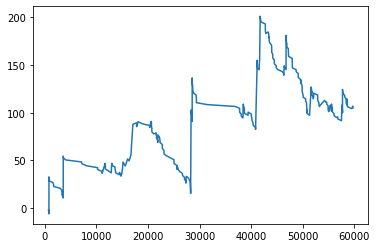

447
{'std_min': 0.0008632531560318053, 'win_or_placed': 0.07587823927093099, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.14542333934036, 'odds_max': 51.72742557258633}
$$  0.3230769230769231
p/b 0.3230769230769231
% 0.03503184713375796
c 325
1516.6666666666667
-1516.6666666666667
325
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   

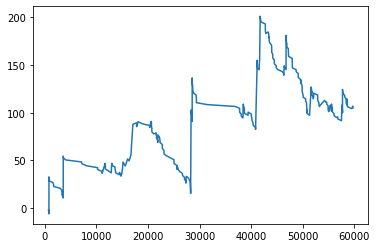

442
{'std_min': 0.0008848912051709527, 'win_or_placed': 0.6567277533129707, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.181657664900005, 'odds_max': 51.60682641455119}
$$  0.3374613003095975
p/b 0.3374613003095975
% 0.035256410256410256
c 323
1507.3333333333333
-1507.3333333333333
323
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10  

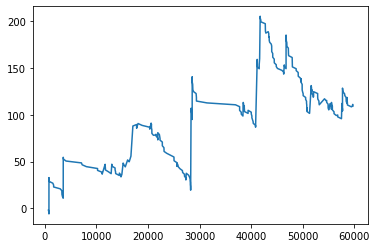

443
{'std_min': 0.000880605779885337, 'win_or_placed': 0.6737966942044701, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.17452402832909, 'odds_max': 51.63093406194163}
$$  0.3374613003095975
p/b 0.3374613003095975
% 0.035256410256410256
c 323
1507.3333333333333
-1507.3333333333333
323
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   


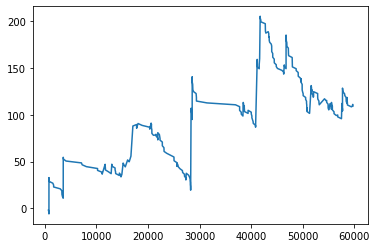

441
{'std_min': 0.0008890855063762484, 'win_or_placed': 0.9669923929647533, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.188718959929375, 'odds_max': 51.58349191622048}
$$  0.34472049689440987
p/b 0.34472049689440987
% 0.03536977491961415
c 322
1502.6666666666667
-1502.6666666666667
322
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10 

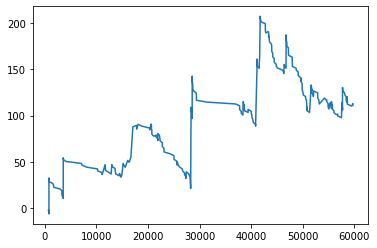

435
{'std_min': 0.0008953143064325363, 'win_or_placed': 0.8153093370997795, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.260831490999, 'odds_max': 51.55588276931587}
$$  0.35202492211838
p/b 0.35202492211838
% 0.035483870967741936
c 321
1498.0
-1498.0
321
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:00     

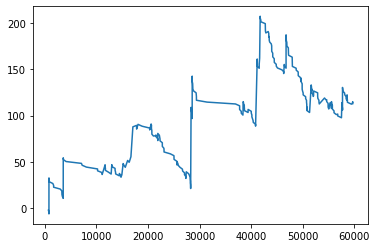

439
{'std_min': 0.0008974993403293198, 'win_or_placed': 0.7877930123852087, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.20257117411532, 'odds_max': 51.53822853773475}
$$  0.35202492211838
p/b 0.35202492211838
% 0.035483870967741936
c 321
1498.0
-1498.0
321
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:00   

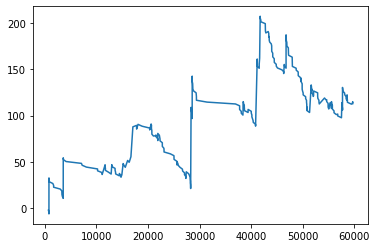

440
{'std_min': 0.0008932584719103837, 'win_or_placed': 0.41291604289957984, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.195748586164843, 'odds_max': 51.560399850803506}
$$  0.35202492211838
p/b 0.35202492211838
% 0.035483870967741936
c 321
1498.0
-1498.0
321
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:00

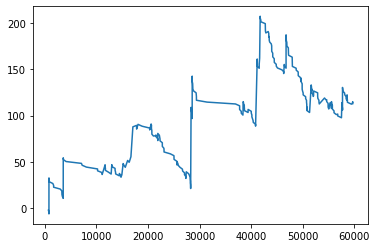

434
{'std_min': 0.0009038136321644677, 'win_or_placed': 0.18725964692208175, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.26771863665214, 'odds_max': 51.507021781654295}
$$  0.3593750000000001
p/b 0.3593750000000001
% 0.03559870550161812
c 320
1493.3333333333333
-1493.3333333333333
320
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10  

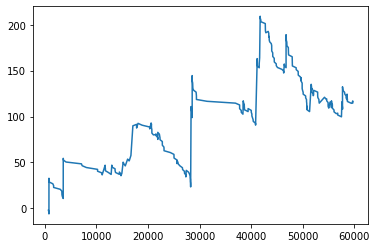

420
{'std_min': 0.0009181304464611902, 'win_or_placed': 0.4989456062832215, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.715554676135955, 'odds_max': 51.57794523099636}
$$  0.3660377358490567
p/b 0.3660377358490567
% 0.035830618892508145
c 318
1484.0
-1484.0
318
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:

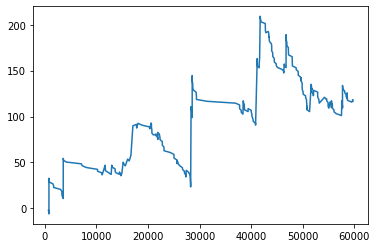

425
{'std_min': 0.0009304149412149649, 'win_or_placed': 0.4056170880456921, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.302339092679674, 'odds_max': 51.32360906991265}
$$  0.3660377358490567
p/b 0.3660377358490567
% 0.035830618892508145
c 318
1484.0
-1484.0
318
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:

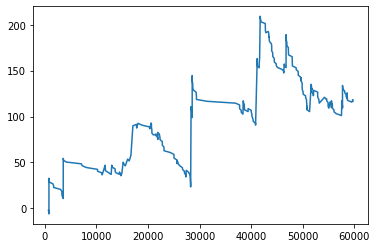

426
{'std_min': 0.0009264410429107383, 'win_or_placed': 0.2917536047703469, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.29629642679849, 'odds_max': 51.34525934263248}
$$  0.3660377358490567
p/b 0.3660377358490567
% 0.035830618892508145
c 318
1484.0
-1484.0
318
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:0

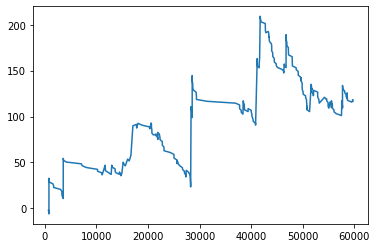

428
{'std_min': 0.0009191796977100947, 'win_or_placed': 0.7519351789736171, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.28407831290066, 'odds_max': 51.434529858440314}
$$  0.3660377358490567
p/b 0.3660377358490567
% 0.035830618892508145
c 318
1484.0
-1484.0
318
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:

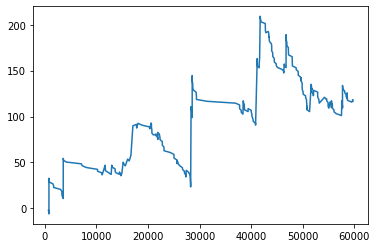

429
{'std_min': 0.0009153421623578776, 'win_or_placed': 0.726309599482776, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.279745475884162, 'odds_max': 51.450541802234696}
$$  0.3660377358490567
p/b 0.3660377358490567
% 0.035830618892508145
c 318
1484.0
-1484.0
318
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:

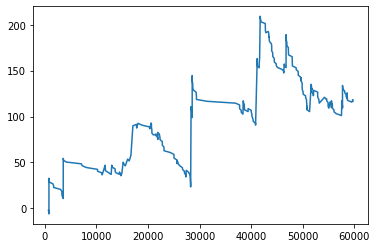

430
{'std_min': 0.0009111572093054571, 'win_or_placed': 0.6520814391780967, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.273861290962596, 'odds_max': 51.4714862721187}
$$  0.3660377358490567
p/b 0.3660377358490567
% 0.035830618892508145
c 318
1484.0
-1484.0
318
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:0

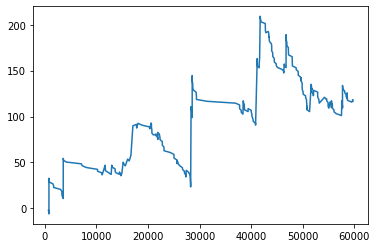

432
{'std_min': 0.0009095514736747855, 'win_or_placed': 0.23217202169320905, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.275574419787553, 'odds_max': 51.47425528012162}
$$  0.3660377358490567
p/b 0.3660377358490567
% 0.035830618892508145
c 318
1484.0
-1484.0
318
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37

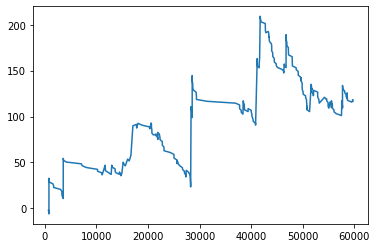

295
{'std_min': 0.0011710250192460156, 'win_or_placed': 0.2365099906136299, 'bet_mul1': 1, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 1, 'odds_min': 22.65122443197843, 'odds_max': 50.2017976963291}
$$  1.5550607287449394
p/b 0.2650793650793651
% 0.03347280334728033
c 247
1482.0
-1482.0
247
2020-01-03 12:55:00 2020-06-30 18:05:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  5.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  6.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  6.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  6.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  6.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  6.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  6.0      10   
1732 2020-01-05 15:37:00 

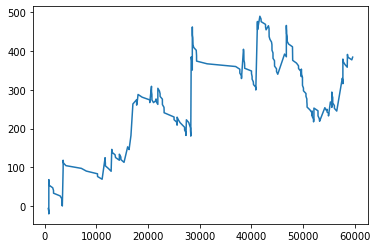

453
{'std_min': 0.0008405730331907594, 'win_or_placed': 0.15675390487383406, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.097773046314753, 'odds_max': 51.84372232692979}
$$  0.2672672672672673
p/b 0.2672672672672673
% 0.034161490683229816
c 333
1443.0
-1443.0
333
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37

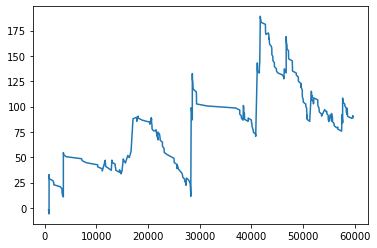

454
{'std_min': 0.0008339552921963393, 'win_or_placed': 0.4432152401414633, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.09980615623051, 'odds_max': 51.883217479022086}
$$  0.2672672672672673
p/b 0.2672672672672673
% 0.034161490683229816
c 333
1443.0
-1443.0
333
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:

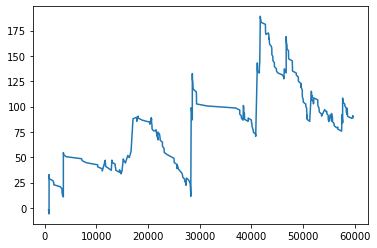

455
{'std_min': 0.0008325018255915404, 'win_or_placed': 0.794519531117626, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.09402040715543, 'odds_max': 51.906034855955866}
$$  0.2672672672672673
p/b 0.2672672672672673
% 0.034161490683229816
c 333
1443.0
-1443.0
333
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:0

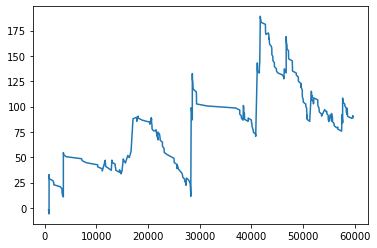

456
{'std_min': 0.0008285602054399704, 'win_or_placed': 0.25163892606484806, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.087629132300464, 'odds_max': 51.92796285581492}
$$  0.2672672672672673
p/b 0.2672672672672673
% 0.034161490683229816
c 333
1443.0
-1443.0
333
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37

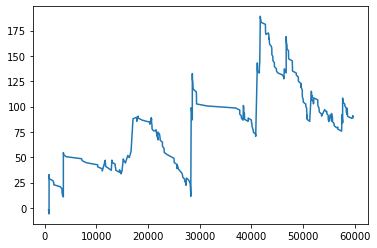

457
{'std_min': 0.0008246171122331816, 'win_or_placed': 0.4513234905450614, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.08104682402942, 'odds_max': 51.95223745681682}
$$  0.2672672672672673
p/b 0.2672672672672673
% 0.034161490683229816
c 333
1443.0
-1443.0
333
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:0

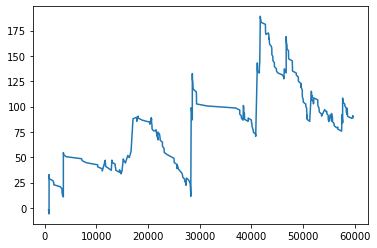

458
{'std_min': 0.0008166551664384596, 'win_or_placed': 0.8684868464812413, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.06498373094486, 'odds_max': 51.93477933789055}
$$  0.2672672672672673
p/b 0.2672672672672673
% 0.034161490683229816
c 333
1443.0
-1443.0
333
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37:0

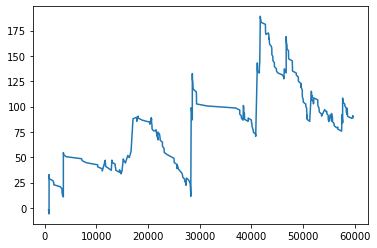

459
{'std_min': 0.0008166624301928618, 'win_or_placed': 0.6132213207809002, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.066960239899416, 'odds_max': 51.993989837531764}
$$  0.2672672672672673
p/b 0.2672672672672673
% 0.034161490683229816
c 333
1443.0
-1443.0
333
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   
1732 2020-01-05 15:37

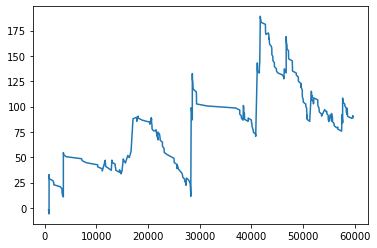

452
{'std_min': 0.0008441112119006372, 'win_or_placed': 0.1511029518212838, 'bet_mul1': 0, 'bet_mul2': 1, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 5, 'n2': 0, 'odds_min': 22.113424383332365, 'odds_max': 51.83637299000276}
$$  0.3018292682926829
p/b 0.3018292682926829
% 0.03470031545741325
c 328
1421.3333333333333
-1421.3333333333333
328
2020-01-03 12:55:00 2020-06-30 20:15:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
723  2020-01-03 12:55:00            FURAX    79991  0.419365  1.0       4   
815  2020-01-03 15:17:00       RIO SALSAS    79995  0.661355  1.0       7   
824  2020-01-03 15:35:00  GRACE OF CLIFFS    79986 -0.063929  1.0       6   
828  2020-01-03 15:35:00      NEFYN BEACH    79986 -0.063929  1.0       7   
841  2020-01-03 15:52:00          ALGAIDA    79996 -0.131316  1.0      11   
843  2020-01-03 15:52:00       ENCANTADOR    79996 -0.131316  1.0       7   
1578 2020-01-05 11:55:00       BELLE CORA    80068 -1.727705  1.0      10   

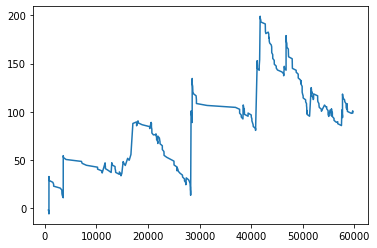

In [206]:
#res_gp.x_iters
indices = [index for index, value in sorted(enumerate(res_gp.func_vals), reverse=False, key=lambda x: x[1])][:40]
#res_gp.func_vals
#res_gp.x
#res_gp.fun

from matplotlib import pyplot as plt

for indice in indices:
    print(indice)
    print(ff(res_gp.x_iters[indice]))
    
    g['stash'] = g['profit'].cumsum()
    print(len(g))
    print(g['start_at'].min(), g['start_at'].max())
    print(g[['start_at', 'horse_name', 'race_id', 'prize', 'bet', 'odds_n', 'sub_category', 'final_odds', 'winner_dividend', 'placed_dividend', 'position', 'bet', 'profit', 'stash']].head(10))
    g['stash'].plot()
    plt.show()

{'std_min': 0.0004, 'win_or_placed': 1, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'INCONNU', 'n1': 0, 'n2': 0, 'odds_min': 0, 'odds_max': 20}
$$  -0.2798755186721992
p/b -0.2798755186721992
% 0.19012345679012346
c 482
18.420382165605094
INCONNU [0.0004, 1, 0, 0, 'INCONNU', 0, 0, 0, 20] -18.420382165605094
482 0.008506565903205084
2020-01-01 14:40:00 2020-06-29 17:37:00
               start_at          horse_name  race_id     prize  bet  odds_n  \
128 2020-01-01 14:40:00     FIERTE DE BRION    79917  0.463101  1.0       4   
215 2020-01-01 16:29:00        BARON DAIDOU    79920  1.283288  1.0       4   
266 2020-01-01 17:35:00      FLYCOERE FOLLE    79922  0.624147  1.0       6   
309 2020-01-01 18:48:00        GRIZZLY BEAR    79924  0.463101  1.0       5   
399 2020-01-02 14:14:00        GIULETTA JET    79959  1.214662  1.0       2   
428 2020-01-02 14:46:00  GEORGIA ON MY MIND    79960  0.463101  1.0       0   
480 2020-01-02 15:57:00   FALCO D'HAVAROCHE    79962  0.624147  1.0  

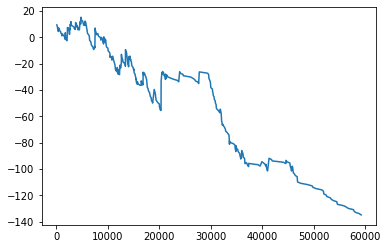

{'std_min': 0.0004, 'win_or_placed': 1, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'AUTOSTART', 'n1': 0, 'n2': 0, 'odds_min': 0, 'odds_max': 20}
$$  -0.19869451697127935
p/b -0.19869451697127935
% 0.17846153846153845
c 383
33.5125
AUTOSTART [0.0004, 1, 0, 0, 'AUTOSTART', 0, 0, 0, 20] -33.5125
383 0.00877782591263854
2020-01-01 13:34:00 2020-06-28 18:15:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
77   2020-01-01 13:34:00           CONCERTO    79930 -2.137059  1.0       4   
218  2020-01-01 16:44:00         DAILY CASH    79938 -1.858999  1.0       4   
275  2020-01-01 17:52:00    EVIDENCE D'ELMA    79940 -2.005771  1.0       0   
320  2020-01-01 19:00:00     DE SANKT PAULI    79942 -1.727705  1.0       6   
897  2020-01-03 17:20:00         DEFI MAGIK    80005 -1.608932  1.0       7   
1042 2020-01-04 11:00:00           EASY JOY    80023 -0.131316  1.0       7   
1063 2020-01-04 11:32:00    ELIXIR DE FRECA    80024 -0.131316  1.0       4   
1267 

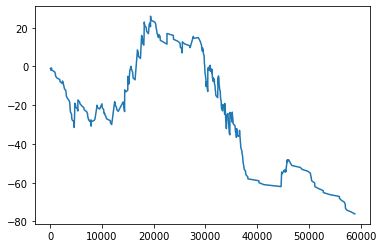

{'std_min': 0.0004, 'win_or_placed': 1, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'COURSE_A_CONDITIONS', 'n1': 0, 'n2': 0, 'odds_min': 0, 'odds_max': 20}
$$  -0.10515970515970517
p/b -0.10515970515970517
% 0.24085365853658536
c 407
41.53061224489796
COURSE_A_CONDITIONS [0.0004, 1, 0, 0, 'COURSE_A_CONDITIONS', 0, 0, 0, 20] -41.53061224489796
407 0.010813542651574004
2020-01-01 13:18:00 2020-06-30 18:05:00
                start_at       horse_name  race_id     prize  bet  odds_n  \
73   2020-01-01 13:18:00            NURMI    79932  0.624147  1.0       3   
632  2020-01-02 18:25:00  MOUNTAIN HUNTER    79976  2.501381  1.0       0   
725  2020-01-03 12:55:00         UNIKETAT    79991  0.419365  1.0       6   
765  2020-01-03 14:25:00          ALFIERI    79984  0.060810  1.0       2   
812  2020-01-03 15:17:00         LASKALIN    79995  0.661355  1.0       0   
820  2020-01-03 15:35:00           SA SAL    79986 -0.063929  1.0       0   
835  2020-01-03 15:52:00    GRIS D'ARGENT    79

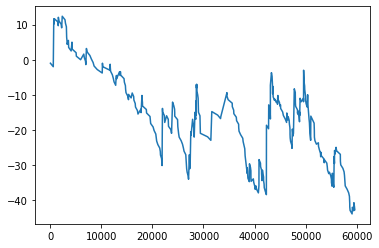

{'std_min': 0.0004, 'win_or_placed': 1, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP', 'n1': 0, 'n2': 0, 'odds_min': 0, 'odds_max': 20}
$$  0.02530487804878048
p/b 0.02530487804878048
% 0.21033210332103322
c 328
6.905263157894737
HANDICAP [0.0004, 1, 0, 0, 'HANDICAP', 0, 0, 0, 20] -6.905263157894737
328 0.0103138677892265
2020-01-02 16:05:00 2020-06-29 21:00:00
                start_at    horse_name  race_id     prize  bet  odds_n  \
494  2020-01-02 16:05:00     ALMANAARA    79972  2.177924  1.0       5   
573  2020-01-02 17:15:00        TAAMOL    79974  2.501381  1.0       1   
712  2020-01-03 12:40:00        SAUZON    79981  0.000000  1.0       0   
778  2020-01-03 14:42:00   GLORIA BERE    79994  0.060810  1.0       1   
1440 2020-01-04 19:15:00       QASWARA    80046 -1.919134  1.0       4   
1523 2020-01-04 22:00:00    LADY DAKAR    80056 -3.384159  1.0       2   
1540 2020-01-04 22:15:00  LUCKY WINNER    80052 -1.295112  1.0      12   
1545 2020-01-04 22:45:00  EL GR

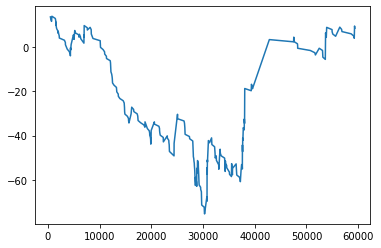

{'std_min': 0.0004, 'win_or_placed': 1, 'bet_mul1': 0, 'bet_mul2': 0, 'sub_categories': 'HANDICAP_DIVISE', 'n1': 0, 'n2': 0, 'odds_min': 0, 'odds_max': 20}
$$  -0.04516129032258062
p/b -0.04516129032258062
% 0.12318840579710146
c 155
24.8
HANDICAP_DIVISE [0.0004, 1, 0, 0, 'HANDICAP_DIVISE', 0, 0, 0, 20] -24.8
155 0.009650166023578748
2020-01-02 13:55:00 2020-06-28 15:15:00
                start_at         horse_name  race_id     prize  bet  odds_n  \
378  2020-01-02 13:55:00        SPANISH ONE    79945  2.005970  1.0       1   
517  2020-01-02 16:31:00  ESCAPADE NOCTURNE    79963 -0.358549  1.0       1   
550  2020-01-02 16:47:00          VERY DEAL    79950 -0.202554  1.0       6   
570  2020-01-02 17:02:00       LA JUBANAISE    79964 -0.636657  1.0       5   
584  2020-01-02 17:18:00      BAIE D'ARGUIN    79951  0.060810  1.0       3   
742  2020-01-03 13:50:00             MOUDIR    79983  1.190921  1.0       6   
855  2020-01-03 16:10:00        HEPTATHLETE    79987 -0.202554  1.0    

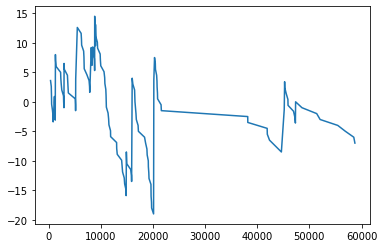

In [209]:
params = res_gp.x_iters[405]
categories = df['sub_category'].value_counts().index[0:5]

for cat in categories:
    params = [0.0004, 1, 0, 0, cat, 0, 0, 0, 20]
    print(cat, params, ff(params))

    from matplotlib import pyplot as plt

    g['stash'] = g['profit'].cumsum()
    print(len(g), g['pred_y1'].mean())
    print(g['start_at'].min(), g['start_at'].max())
    print(g[['start_at', 'horse_name', 'race_id', 'prize', 'bet', 'odds_n', 'sub_category', 'final_odds', 'winner_dividend', 'placed_dividend', 'position', 'bet', 'profit', 'stash']].head(10))
    g['stash'].plot()
    plt.show()

In [211]:
from cataclop.ml.exploration import random_race

r = random_race(df_test, ['position', 'sub_category', 'num', 'final_odds', 'final_odds_ref_real', 'odds_n'] + ['pred_y{}'.format(i+1) for i in range(y.shape[1])] + ['pred_n{}'.format(i+1) for i in range(y.shape[1])]).sort_values(by='position')

r

position sub_category  num  final_odds  final_odds_ref_real  \
race_id                                                                    
79973   538       1.0     HANDICAP   11        12.0                 12.0   
        534       2.0     HANDICAP    7        13.0                  6.6   
        529       3.0     HANDICAP    2         3.1                  6.9   
        531       3.0     HANDICAP    4         7.6                  3.8   
        535       5.0     HANDICAP    8         9.9                  5.1   
        528       6.0     HANDICAP    1         6.4                 11.0   
        533       7.0     HANDICAP    6        13.0                  9.4   
        530       8.0     HANDICAP    3        11.0             100000.0   
        536       9.0     HANDICAP    9        30.0                 13.0   
        540      10.0     HANDICAP   13         9.1                 14.0   
        532      20.0     HANDICAP    5         NaN             100000.0   
        537      20.0     HANDICAP   10         NaN             100000.0   
        539      20.0     HANDICAP   12         8.1                  8.1   

             odds_n   pred_y1   pred_y2  pred_n1  pred_n2  
race_id                                                    
79973   538       7  0.008125  0.009320        7        9  
        534       9  0.008736  0.010107        5        6  
        529       0  0.009231  0.010346        3        4  
        531       2  0.007334  0.008964        9       10  
        535       5  0.010825  0.011930        1        0  
        528       1  0.009190  0.010751        4        3  
        533       8  0.008623  0.009945        6        7  
        530       6  0.011105  0.011813        0        1  
        536      10  0.005590  0.008110       12       11  
        540       4  0.007160  0.009326       10        8  
        532      11  0.006408  0.007949       11       12  
        537      12  0.007996  0.010337        8        5  
        539       3  0.009789  0.011186        2        2